# !!! This notebook was written to be run using Google Colab !!!

This notebook contains experiments to determine the best type of model to use for predicting churn and tuning the individual models.

In [12]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
from pprint import pprint as pp
import pickle
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.ensemble import RandomForestClassifier

!pip install --q catboost
from catboost import CatBoostClassifier

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTENC
import xgboost as xgb

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir_data= <YOUR DATA DIRECTORY>

cleaned_df = pd.read_csv(dir_data + "/cleaned_telco_data.csv", index_col=0)

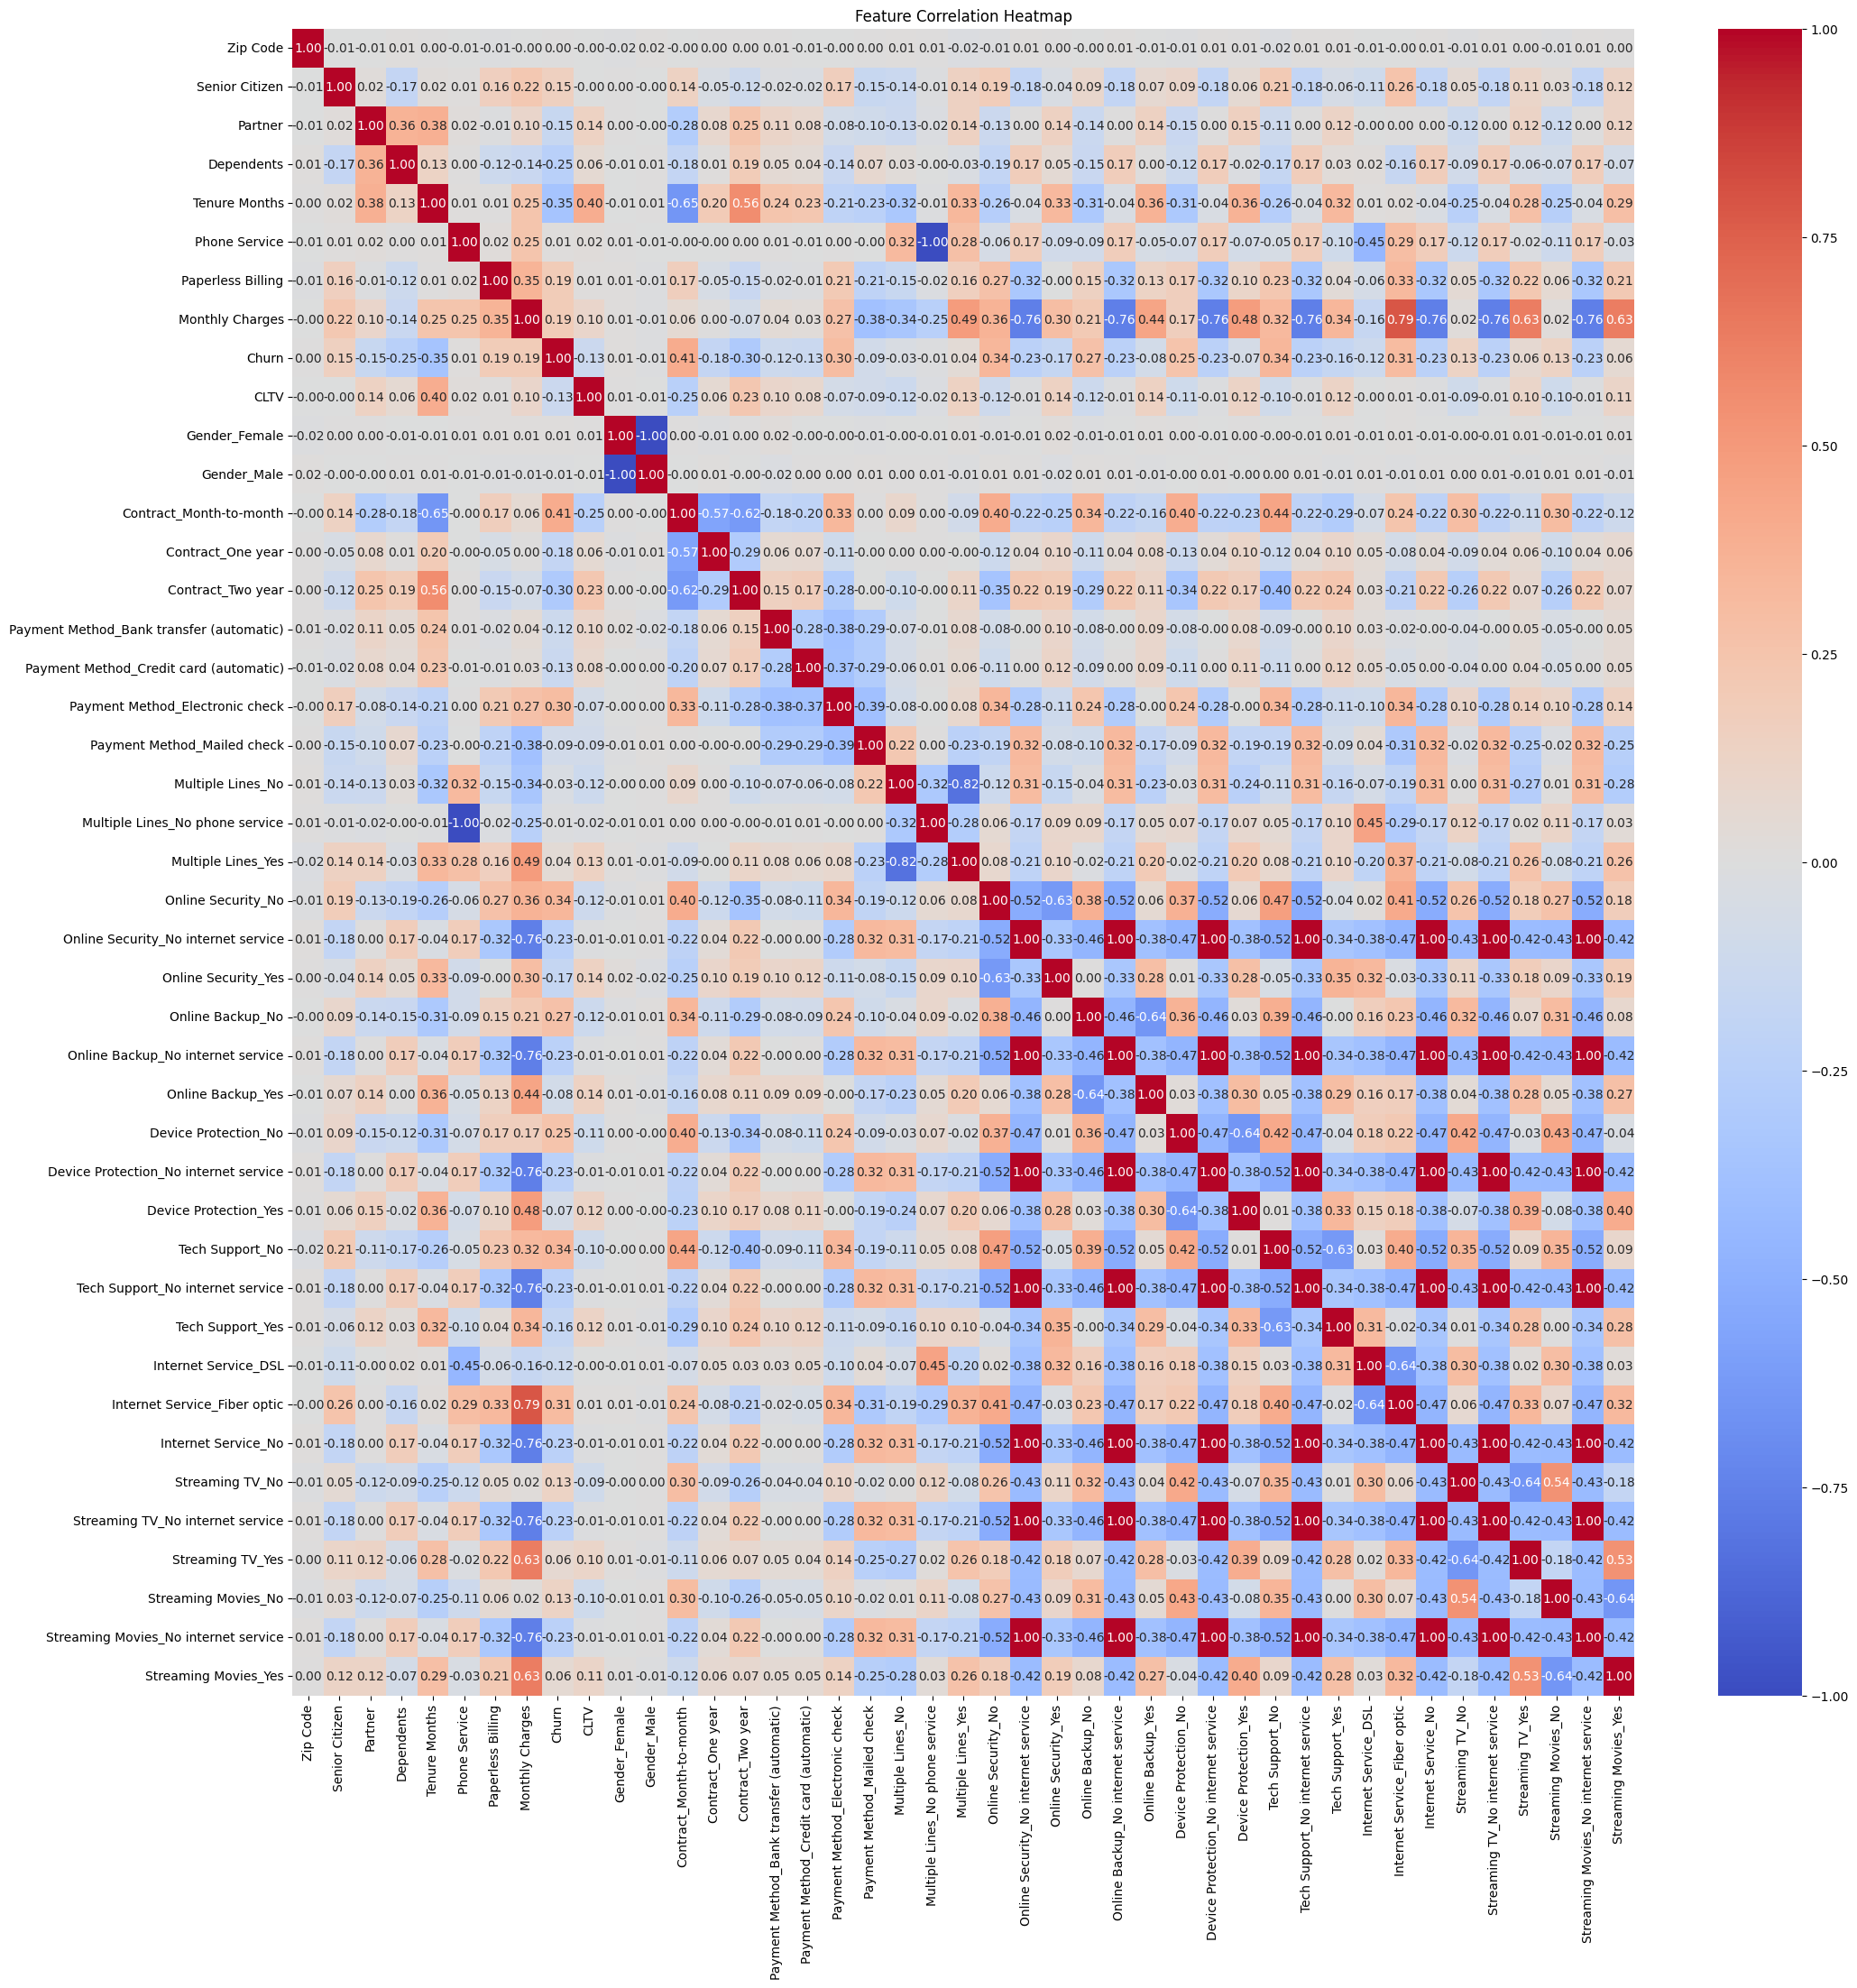

In [3]:
corr = cleaned_df.corr()
plt.figure(figsize=(24, 24))
sns.heatmap(corr,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [4]:
# From the correlation heat map, we can see that 'Multiple Lines_No phone service'
# is perfectly correlated with 'Phone Service', and 'XX_No internet service'
# columns are perfectly correlated with 'Internet service_No'.  We'll remove the
# encoded columns that have this correlation.

corr_cols = ['Multiple Lines_No phone service', 'Online Security_No internet service',
             'Online Backup_No internet service', 'Device Protection_No internet service',
             'Tech Support_No internet service', 'Streaming TV_No internet service',
             'Streaming Movies_No internet service']

cleaned_df = cleaned_df.drop(corr_cols, axis=1)

In [5]:
numeric_cols = ['Tenure Months', 'Monthly Charges', 'CLTV']
RANDOM_STATE = 42

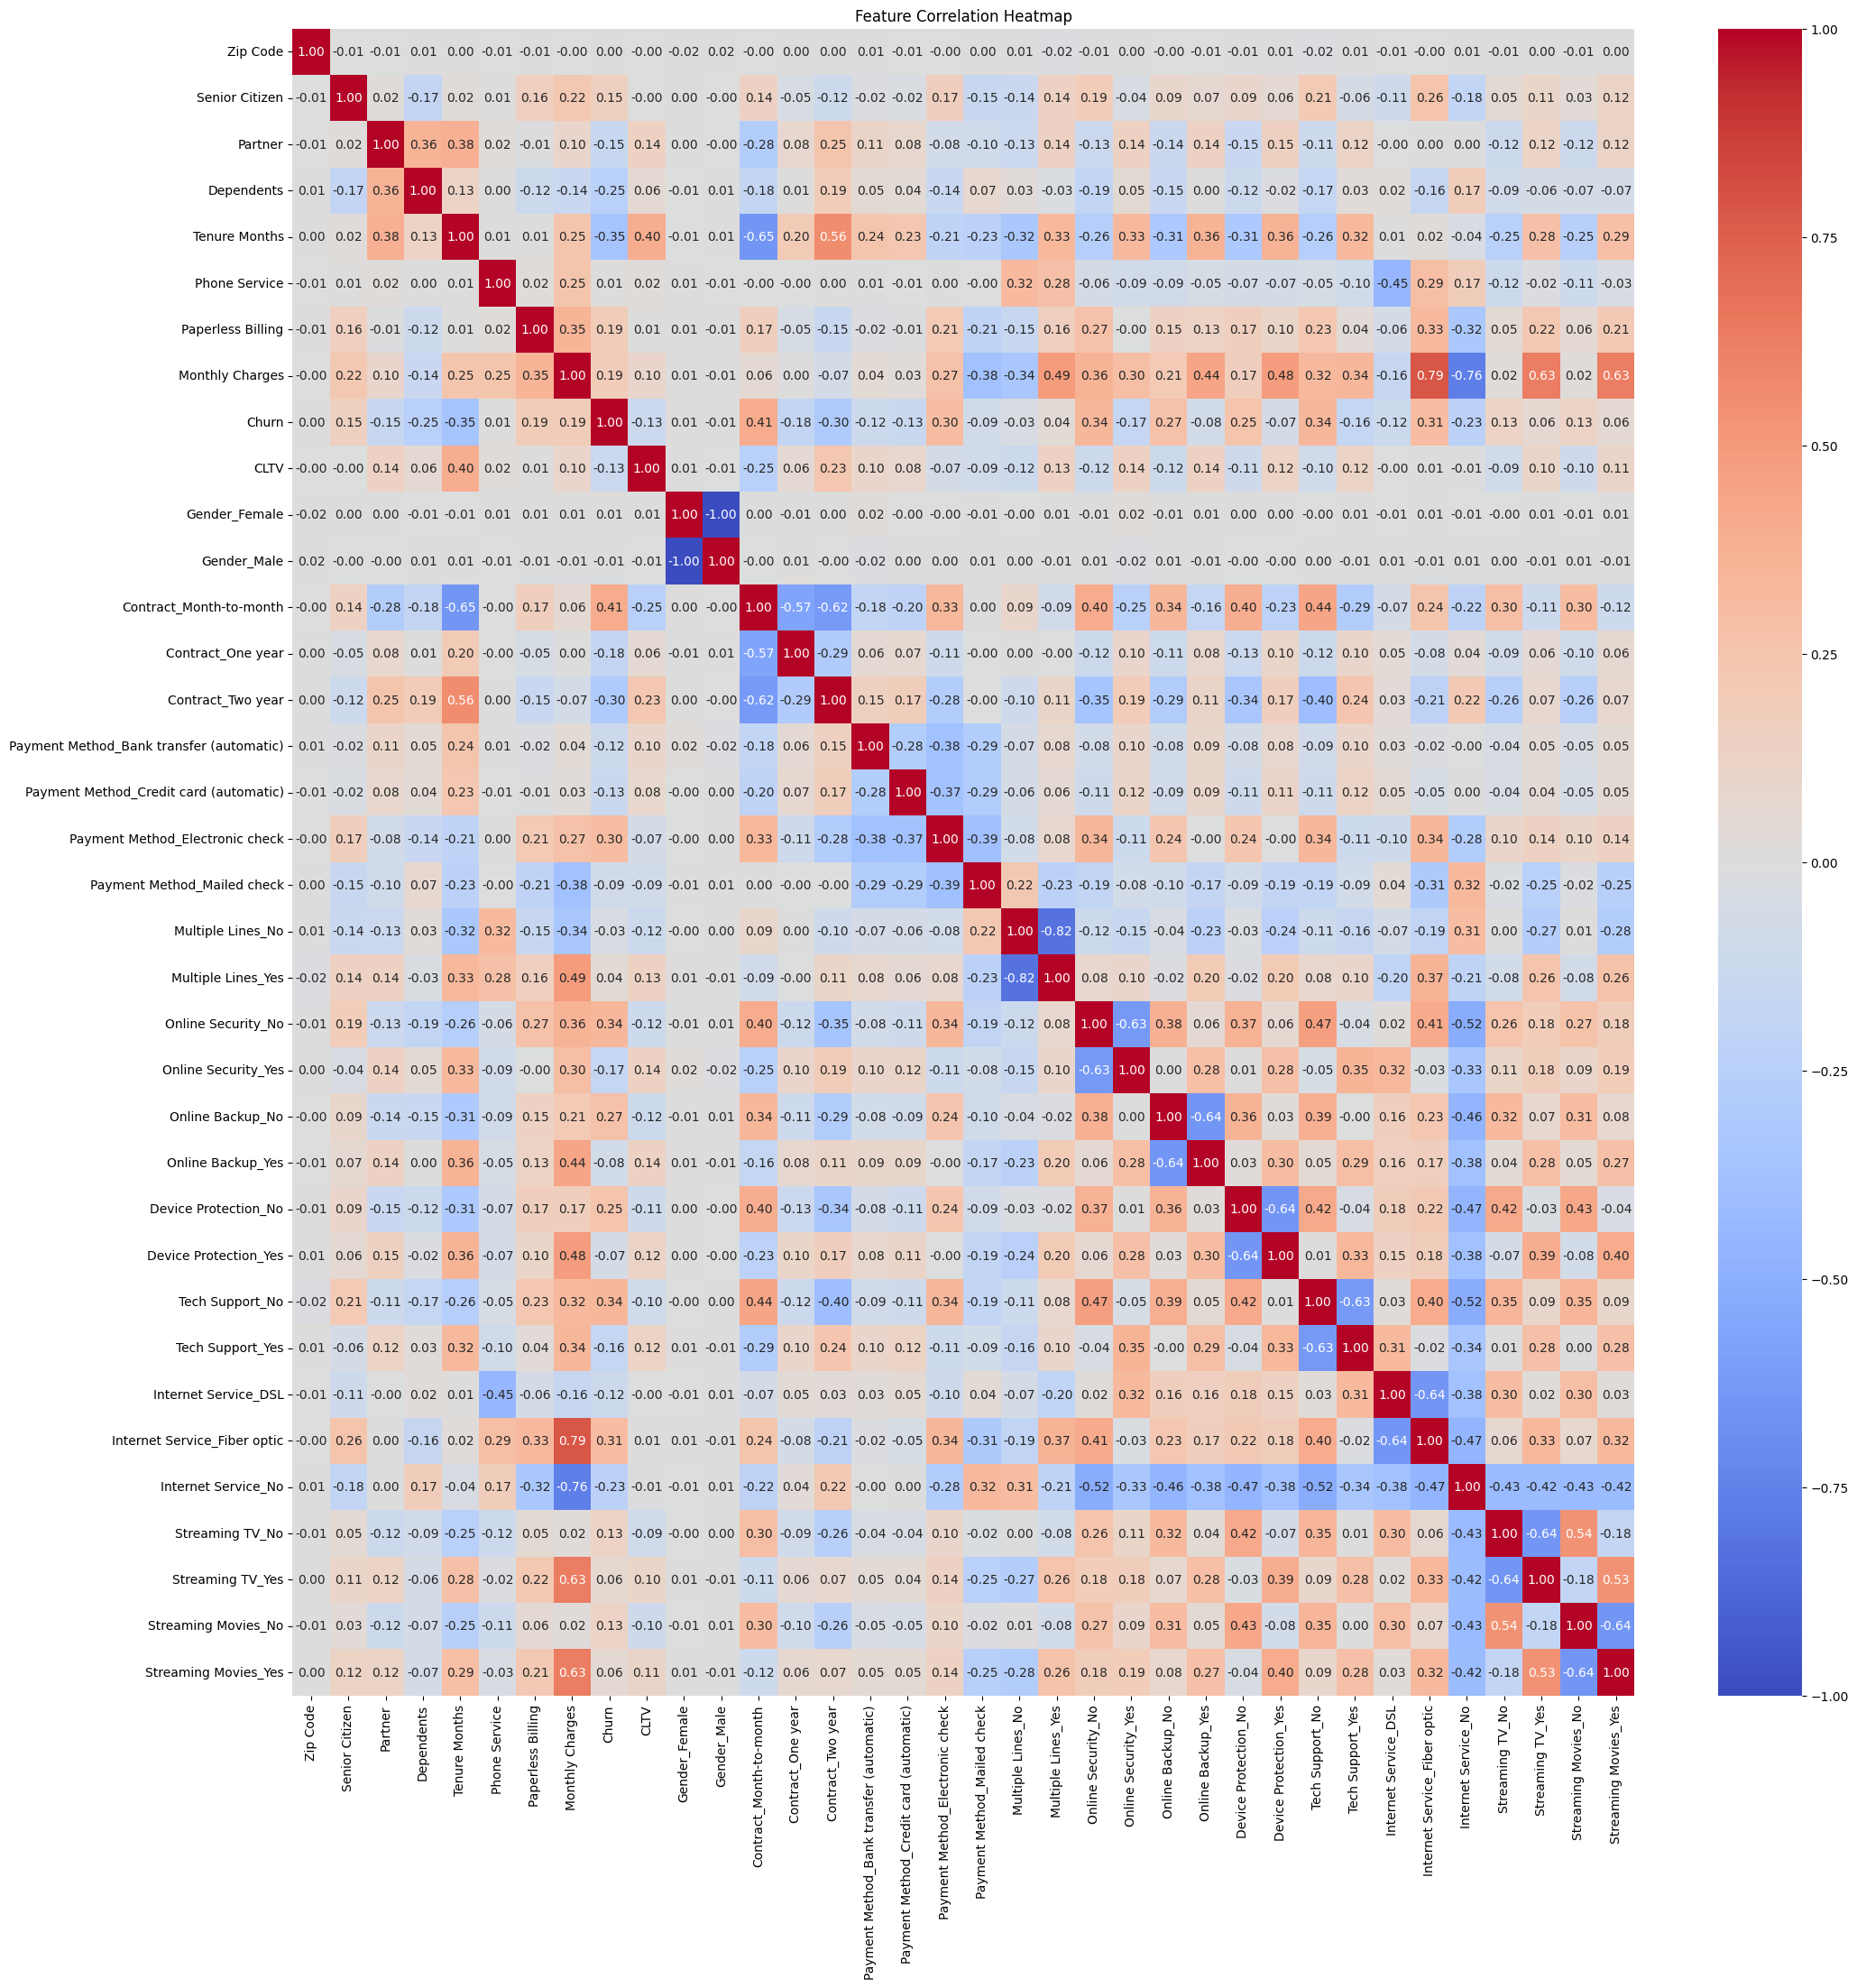

In [6]:
corr = cleaned_df.corr()
plt.figure(figsize=(24, 24))
sns.heatmap(corr,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# Linear Regression
Our first experiment will be using LogisticRegression with an L1 penalty, L2 penalty and no penalty to make predictions.  We'll first look at performance without using SMOTE and compare it to using SMOTE to address class imbalance (as well as the built in `class_weight`).

In [7]:
# Create a helper function to measure the lift of a model
# By default we will assume 10% for the percentage we are
# targeting.

def lift_at_k(y_true, y_scores, k=0.1):
    n = len(y_true)
    cutoff = int(n * k)

    # Sort by predicted churn probability (descending)
    df = pd.DataFrame({"y": y_true, "score": y_scores})
    df = df.sort_values("score", ascending=False)

    # Top K%
    topk = df.head(cutoff)

    # Churn rate in top K%
    churn_topk = topk["y"].mean()

    # Overall churn rate
    churn_base = df["y"].mean()

    # Lift
    return churn_topk / churn_base

In [8]:
# Perform the train / test split once so we can use the same split across
# every model.  This will be important for creating lift and PRAUC charts
# that compare each model.
#
# We'll use a train / test split with 70/30 and stratification of the
# Churn value.

X = cleaned_df.drop(['Churn'], axis=1)
y = cleaned_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
      X,
      y,
      test_size=0.3,
      random_state=RANDOM_STATE,
      stratify=y
)

In [9]:

def train_ridge(imbalance_correction='none', penalty=None, solver=None):
  # We only want to scale the numeric columns, so we need to define it as a
  # pre-processing step
  preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
    ],
    remainder="passthrough"      # keep all other (OHE) columns as-is
  )

  cat_idx = [X.columns.get_loc(c) for c in X.columns if c not in numeric_cols]

  if imbalance_correction == 'none':
    pipeline = Pipeline([
        ('prep', preprocess),
        ('clf', LogisticRegression(
          penalty=penalty,
          solver=solver,
          max_iter=2000,
          random_state=RANDOM_STATE
      ))
    ])
  elif imbalance_correction == 'class_weight':
    pipeline = Pipeline([
        ('prep', preprocess),
        ('clf', LogisticRegression(
          penalty=penalty,
          solver=solver,
          class_weight='balanced',
          max_iter=2000,
          random_state=RANDOM_STATE
      ))
    ])
  elif imbalance_correction == 'smote':
    pipeline = Pipeline([
        ('prep', preprocess),
        ('smote', SMOTENC(categorical_features=cat_idx, random_state=RANDOM_STATE)),
        ('clf', LogisticRegression(
          penalty=penalty,
          solver=solver,
          max_iter=3000,
          random_state=RANDOM_STATE
      ))
    ])

  # We're going to use StratifiedKFold since:
  # 1. We want to have stratification due to class imbalance
  # 2. It allows us to specify a random state so we can have reproduceable
  #    models.
  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
  param_grid = {
    "clf__C": [0.01, 0.1, 0.3, 1, 3, 10]
  }

  gs_lr = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="average_precision",  # AUPRC is best for churn
    cv=cv,
    n_jobs=-1,
    refit=True
  )

  gs_lr.fit(X_train, y_train)
  model = gs_lr.best_estimator_

  y_scores = model.predict_proba(X_test)[:, 1]
  lift = lift_at_k(y_test, y_scores, k=0.1)

  print('   Best C:', gs_lr.best_params_['clf__C'])
  print('   Best CV AUPRC:', gs_lr.best_score_)
  print('   Best Lift score:', lift)


  return model, gs_lr.best_score_, lift

model_configs = [
    {'name': 'LogisticRegression L2 No Imbalance Correction',
     'correction': 'none',
     'solver': 'lbfgs',
     'penalty': 'l2'},
    {'name': 'LogisticRegression L2 Class Weight Imbalance Correction',
     'correction': 'class_weight',
     'solver': 'lbfgs',
     'penalty': 'l2'},
    {'name': 'LogisticRegression L2 SMOTE Imbalance Correction',
     'correction': 'smote',
     'solver': 'lbfgs',
     'penalty': 'l2'},
    {'name': 'LogisticRegression L1 No Imbalance Correction',
     'correction': 'none',
     'solver': 'liblinear',
     'penalty': 'l1'},
    {'name': 'LogisticRegression L1 Class Weight Imbalance Correction',
     'correction': 'class_weight',
     'solver': 'liblinear',
     'penalty': 'l1'},
    {'name': 'LogisticRegression L1 SMOTE Imbalance Correction',
     'correction': 'smote',
     'solver': 'liblinear',
     'penalty': 'l1'},
    {'name': 'LogisticRegression No Imbalance Correction',
     'correction': 'none',
     'solver': 'lbfgs',
     'penalty': None},
    {'name': 'LogisticRegression Class Weight Imbalance Correction',
     'correction': 'class_weight',
     'solver': 'lbfgs',
     'penalty': None},
    {'name': 'LogisticRegression SMOTE Imbalance Correction',
     'correction': 'smote',
     'solver': 'lbfgs',
     'penalty': None}
]

results_data = []
lr_models = {}

for config in model_configs:
  print(f'---------------------------- {config["name"]} ----------------------------')
  mdl, mdl_auprc, lift = train_ridge(
      imbalance_correction=config['correction'],
      penalty=config['penalty'],
      solver=config['solver']
  )

  lr_models[config['name']] = mdl
  results_data.append({
      'model_name': config['name'],
      'correction': config['correction'],
      'auprc': mdl_auprc,
      'lift': lift
  })

lr_results_df = pd.DataFrame(results_data)
lr_results_df

---------------------------- LogisticRegression L2 No Imbalance Correction ----------------------------
   Best C: 0.3
   Best CV AUPRC: 0.6773963939721668
   Best Lift score: 2.8918062701168363
---------------------------- LogisticRegression L2 Class Weight Imbalance Correction ----------------------------
   Best C: 1
   Best CV AUPRC: 0.6764198197320681
   Best Lift score: 2.9096569261052116
---------------------------- LogisticRegression L2 SMOTE Imbalance Correction ----------------------------
   Best C: 3
   Best CV AUPRC: 0.6776029865420361
   Best Lift score: 2.7490010222098316
---------------------------- LogisticRegression L1 No Imbalance Correction ----------------------------
   Best C: 10
   Best CV AUPRC: 0.6796822394541439
   Best Lift score: 2.856104958140085
---------------------------- LogisticRegression L1 Class Weight Imbalance Correction ----------------------------
   Best C: 10
   Best CV AUPRC: 0.6784225639093957
   Best Lift score: 2.856104958140085
----------

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


   Best C: 0.01
   Best CV AUPRC: 0.6766765971770861
   Best Lift score: 2.8739556141284606
---------------------------- LogisticRegression Class Weight Imbalance Correction ----------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


   Best C: 0.01
   Best CV AUPRC: 0.6762283641776976
   Best Lift score: 2.9096569261052116
---------------------------- LogisticRegression SMOTE Imbalance Correction ----------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


   Best C: 0.01
   Best CV AUPRC: 0.6780702282453781
   Best Lift score: 2.7311503662214562


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_name,correction,auprc,lift
0,LogisticRegression L2 No Imbalance Correction,none,0.677396,2.891806
1,LogisticRegression L2 Class Weight Imbalance C...,class_weight,0.676420,2.909657
2,LogisticRegression L2 SMOTE Imbalance Correction,smote,0.677603,2.749001
3,LogisticRegression L1 No Imbalance Correction,none,0.679682,2.856105
4,LogisticRegression L1 Class Weight Imbalance C...,class_weight,0.678423,2.856105
5,LogisticRegression L1 SMOTE Imbalance Correction,smote,0.677341,2.820404
6,LogisticRegression No Imbalance Correction,none,0.676677,2.873956
7,LogisticRegression Class Weight Imbalance Corr...,class_weight,0.676228,2.909657
8,LogisticRegression SMOTE Imbalance Correction,smote,0.678070,2.731150


# Random Forest
Next we will train Random Forest Models.

In [10]:
categorical_cols = [c for c in cleaned_df.drop(['Churn'], axis=1).columns if c not in numeric_cols]
print(categorical_cols)

['Zip Code', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing', 'Gender_Female', 'Gender_Male', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'Payment Method_Bank transfer (automatic)', 'Payment Method_Credit card (automatic)', 'Payment Method_Electronic check', 'Payment Method_Mailed check', 'Multiple Lines_No', 'Multiple Lines_Yes', 'Online Security_No', 'Online Security_Yes', 'Online Backup_No', 'Online Backup_Yes', 'Device Protection_No', 'Device Protection_Yes', 'Tech Support_No', 'Tech Support_Yes', 'Internet Service_DSL', 'Internet Service_Fiber optic', 'Internet Service_No', 'Streaming TV_No', 'Streaming TV_Yes', 'Streaming Movies_No', 'Streaming Movies_Yes']


In [13]:


def train_random_forest(imbalance_correction=None):
  # Only scale the numeric columns
  pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols)
    ],
    remainder="passthrough"
  )
  n_num = len(numeric_cols)
  n_cat = len(categorical_cols)
  cat_idx = list(range(n_num, n_num + n_cat))

  steps = [("prep", pre)]

  if imbalance_correction == "smote" and n_cat > 0:
    steps.append(("smote", SMOTENC(categorical_features=cat_idx, random_state=42)))

  steps.append(("rf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)))

  pipe = Pipeline(steps=steps)

  # ---- Tune a few useful RF params; score with AUPRC ----
  param_grid = {
    "rf__n_estimators": [100, 300, 500],
    "rf__max_depth": [None, 5, 8, 12],
    "rf__min_samples_split": [2, 5, 10, 20]
  }

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

  gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="average_precision",   # AUPRC for churn
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"
  )

  gs.fit(X_train, y_train)
  best_rf = gs.best_estimator_


  y_scores = best_rf.predict_proba(X_test)[:, 1]
  lift = lift_at_k(y_test, y_scores, k=0.1)

  print('   Best params:', gs.best_params_)
  print('   Best CV AUPRC:', gs.best_score_)
  print('   Best Lift score:', lift)


  return best_rf, gs.best_score_, lift

model_configs = [
    {'name': 'RF no SMOTE',
     'correction': None},
    {'name': 'RF with SMOTE',
     'correction': 'smote'}
]

results_data = []
rf_models = {}

for config in model_configs:
  print(f'---------------------------- {config["name"]} ----------------------------')
  mdl, mdl_auprc, lift = train_random_forest(imbalance_correction=config['correction'])

  rf_models[config['name']] = mdl
  results_data.append({
      'model_name': config['name'],
      'correction': config['correction'],
      'auprc': mdl_auprc,
      'lift': lift
  })

rf_results_df = pd.DataFrame(results_data)
rf_results_df

---------------------------- RF no SMOTE ----------------------------
Fitting 5 folds for each of 48 candidates, totalling 240 fits
   Best params: {'rf__max_depth': 8, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
   Best CV AUPRC: 0.6821373243666301
   Best Lift score: 2.8025529901749584
---------------------------- RF with SMOTE ----------------------------
Fitting 5 folds for each of 48 candidates, totalling 240 fits
   Best params: {'rf__max_depth': 8, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
   Best CV AUPRC: 0.6650571813401955
   Best Lift score: 2.7668516781982073


,model_name,correction,auprc,lift
0,RF no SMOTE,None,0.682137,2.802553
1,RF with SMOTE,smote,0.665057,2.766852


# XGBoost model

In [14]:
def get_class_weights(y_train):
  # We can manually determine weights to make this more equivalent to the
  # LogisticRegression's class_weight.  The formula for each weight is:
  # (total_samples) / (number_of_classes * number_of_samples_in_class)

  total_samples = y_train.shape[0]
  num_classes = 2
  num_pos = y_train.value_counts()[1]
  num_neg = y_train.value_counts()[0]

  pos_weight = (total_samples) / (num_classes * num_pos)
  neg_weight = (total_samples) / (num_classes * num_neg)

  class_weights = {0: neg_weight, 1: pos_weight}
  return class_weights

In [15]:
def train_xgboost(imbalance_correction=None):
  # Only scale the numeric columns
  pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols)
    ],
    remainder="passthrough"
  )
  n_num = len(numeric_cols)
  n_cat = len(categorical_cols)
  cat_idx = list(range(n_num, n_num + n_cat))

  steps = [("prep", pre)]

  if imbalance_correction == "smote" and n_cat > 0:
    steps.append(("smote", SMOTENC(categorical_features=cat_idx, random_state=RANDOM_STATE)))

  # Specify common parameters for the XGBoost model
  params = {
    'eval_metric': 'aucpr'
  }

  if imbalance_correction == 'class_weight':
    scale_pos_weight = get_class_weights(y_train)[1]
    params['scale_pos_weight'] = scale_pos_weight

  steps.append(("model", xgb.XGBClassifier(**params)))

  pipe = Pipeline(steps=steps)

  param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [3, 6, 9]
  }

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

  gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="average_precision",   # AUPRC for churn
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"
  )

  gs.fit(X_train, y_train)
  best_cb = gs.best_estimator_


  y_scores = best_cb.predict_proba(X_test)[:, 1]
  lift = lift_at_k(y_test, y_scores, k=0.1)

  print('   Best params:', gs.best_params_)
  print('   Best CV AUPRC:', gs.best_score_)
  print('   Best Lift score:', lift)


  return best_cb, gs.best_score_, lift

model_configs = [
    {'name': 'XGB No Imbalance Correction',
     'correction': None},
    {'name': 'XGB with SMOTE',
     'correction': 'smote'},
    {'name': 'XGB with Class Weight',
     'correction': 'class_weight'}
]

results_data = []
xgb_models = {}

for config in model_configs:
  print(f'---------------------------- {config["name"]} ----------------------------')
  mdl, mdl_auprc, lift = train_xgboost(imbalance_correction=config['correction'])

  xgb_models[config['name']] = mdl
  results_data.append({
      'model_name': config['name'],
      'correction': config['correction'],
      'auprc': mdl_auprc,
      'lift': lift
  })

xgb_results_df = pd.DataFrame(results_data)
xgb_results_df

---------------------------- XGB No Imbalance Correction ----------------------------
Fitting 5 folds for each of 9 candidates, totalling 45 fits
   Best params: {'model__max_depth': 3, 'model__n_estimators': 100}
   Best CV AUPRC: 0.6637893856905747
   Best Lift score: 2.7668516781982073
---------------------------- XGB with SMOTE ----------------------------
Fitting 5 folds for each of 9 candidates, totalling 45 fits
   Best params: {'model__max_depth': 3, 'model__n_estimators': 100}
   Best CV AUPRC: 0.6531705662528509
   Best Lift score: 2.5704944623260766
---------------------------- XGB with Class Weight ----------------------------
Fitting 5 folds for each of 9 candidates, totalling 45 fits
   Best params: {'model__max_depth': 3, 'model__n_estimators': 100}
   Best CV AUPRC: 0.6610863637439397
   Best Lift score: 2.8204036461633337


,model_name,correction,auprc,lift
0,XGB No Imbalance Correction,None,0.663789,2.766852
1,XGB with SMOTE,smote,0.653171,2.570494
2,XGB with Class Weight,class_weight,0.661086,2.820404


# CatBoost model
Lastly, we'll evaluate how well CatBoost models work for predicting churn.

In [16]:
!pip install --q catboost
from catboost import CatBoostClassifier

def train_catboost(imbalance_correction=None):
  # Specify common parameters for the CatBoost model
  params = {'iterations': 500,
    'eval_metric': 'PRAUC',
    'verbose': 100,
    'od_type': 'Iter',
    'od_wait': 50,
    'random_seed': RANDOM_STATE,
    'loss_function': 'Logloss'
  }

  # Only scale the numeric columns
  pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols)
    ],
    remainder="passthrough"
  )
  n_num = len(numeric_cols)
  n_cat = len(categorical_cols)
  cat_idx = list(range(n_num, n_num + n_cat))

  steps = [("prep", pre)]

  if imbalance_correction == "smote" and n_cat > 0:
    steps.append(("smote", SMOTENC(categorical_features=cat_idx, random_state=RANDOM_STATE)))
  elif imbalance_correction == 'class_weight':
    params['class_weights'] = get_class_weights(y_train)

  steps.append(("model", CatBoostClassifier(**params)))

  pipe = Pipeline(steps=steps)

  param_grid = {
    "model__depth": [4, 6, 8],
    "model__learning_rate": [0.03, 0.05],
  }

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="average_precision",   # AUPRC for churn
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"
  )

  gs.fit(X_train, y_train)
  best_cb = gs.best_estimator_


  y_scores = best_cb.predict_proba(X_test)[:, 1]
  lift = lift_at_k(y_test, y_scores, k=0.1)

  print('   Best params:', gs.best_params_)
  print('   Best CV AUPRC:', gs.best_score_)
  print('   Best Lift score:', lift)


  return best_cb, gs.best_score_, lift

model_configs = [
    {'name': 'CB No Imbalance Correction',
     'correction': None},
    {'name': 'CB with SMOTE',
     'correction': 'smote'},
    {'name': 'CB with Class Weight',
     'correction': 'class_weight'}
]

results_data = []
cb_models = {}

for config in model_configs:
  print(f'---------------------------- {config["name"]} ----------------------------')
  mdl, mdl_auprc, lift = train_catboost(imbalance_correction=config['correction'])

  cb_models[config['name']] = mdl
  results_data.append({
      'model_name': config['name'],
      'correction': config['correction'],
      'auprc': mdl_auprc,
      'lift': lift
  })

cb_results_df = pd.DataFrame(results_data)
cb_results_df

---------------------------- CB No Imbalance Correction ----------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0:	learn: 0.6690870	total: 51.3ms	remaining: 25.6s
100:	learn: 0.7131796	total: 426ms	remaining: 1.68s
200:	learn: 0.7358566	total: 780ms	remaining: 1.16s
300:	learn: 0.7541053	total: 1.16s	remaining: 767ms
400:	learn: 0.7749316	total: 1.52s	remaining: 374ms
499:	learn: 0.7919033	total: 1.87s	remaining: 0us
   Best params: {'model__depth': 4, 'model__learning_rate': 0.03}
   Best CV AUPRC: 0.6865141183725245
   Best Lift score: 2.9453582380819623
---------------------------- CB with SMOTE ----------------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	learn: 0.8613087	total: 4.55ms	remaining: 2.27s
100:	learn: 0.8894060	total: 507ms	remaining: 2s
200:	learn: 0.9030744	total: 1.04s	remaining: 1.55s
300:	learn: 0.9118080	total: 1.61s	remaining: 1.06s
400:	learn: 0.9211768	total: 2.1s	remaining: 517ms
499:	learn: 0.9282812	total: 2.59s	remaining: 0us
   Best params: {'model__depth': 4, 'model__learning_rate': 0.03}
   Best CV AUPRC: 0.6709611481243931
   Best L

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0:	learn: 0.8308757	total: 4.36ms	remaining: 2.18s
100:	learn: 0.8595685	total: 417ms	remaining: 1.65s
200:	learn: 0.8700909	total: 795ms	remaining: 1.18s
300:	learn: 0.8795612	total: 1.2s	remaining: 793ms
400:	learn: 0.8897001	total: 1.57s	remaining: 388ms
499:	learn: 0.8977657	total: 1.98s	remaining: 0us
   Best params: {'model__depth': 4, 'model__learning_rate': 0.03}
   Best CV AUPRC: 0.6870796419269063
   Best Lift score: 2.8918062701168363


,model_name,correction,auprc,lift
0,CB No Imbalance Correction,None,0.686514,2.945358
1,CB with SMOTE,smote,0.670961,2.766852
2,CB with Class Weight,class_weight,0.687080,2.891806


# Feature Removal
To prevent overfitting, we will evaluate the performance of the catboost model as we eliminate the features ranked the lowest in importance.

In [17]:
# The catboost model with the best performance was the one with no imbalance
# correction, so we will remove features from that model until we see a
# significant drop in performance.

cat_model = cb_models['CB No Imbalance Correction'].named_steps["model"]
importances = cat_model.get_feature_importance()
feat_names = (
    numeric_cols + categorical_cols
)

feature_importance_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feature_importance_df

,feature,importance
6,Dependents,25.303313
0,Tenure Months,15.998597
11,Contract_Month-to-month,13.009532
1,Monthly Charges,8.325706
3,Zip Code,6.360115
2,CLTV,4.829625
29,Internet Service_Fiber optic,4.112780
13,Contract_Two year,2.879407
20,Online Security_No,2.738126
26,Tech Support_No,1.998273


In [32]:
feature_importance_df.to_csv(dir_data + '/feature_importance.csv')

In [18]:
def train_catboost_feat_removal(X, y):
  X_train, X_test, y_train, y_test = train_test_split(
      X,
      y,
      test_size=0.3,
      random_state=RANDOM_STATE,
      stratify=y
  )

  # Specify common parameters for the CatBoost model
  params = {'iterations': 500,
    'eval_metric': 'PRAUC',
    'verbose': 100,
    'od_type': 'Iter',
    'od_wait': 50,
    'random_seed': RANDOM_STATE,
    'loss_function': 'Logloss'
  }

  # Only scale the numeric columns.  We know that all the numeric columns are
  # very high in feature importance, so we don't need to make sure we didn't
  # remove them here.
  pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols)
    ],
    remainder="passthrough"
  )

  steps = [
      ("prep", pre),
      (("model", CatBoostClassifier(**params)))
  ]

  pipe = Pipeline(steps=steps)

  param_grid = {
    "model__depth": [4, 6, 8],
    "model__learning_rate": [0.03, 0.05],
  }

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="average_precision",   # AUPRC for churn
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score="raise"
  )

  gs.fit(X_train, y_train)
  best_cb = gs.best_estimator_


  y_scores = best_cb.predict_proba(X_test)[:, 1]
  lift = lift_at_k(y_test, y_scores, k=0.1)

  print('   Best params:', gs.best_params_)
  print('   Best CV AUPRC:', gs.best_score_)
  print('   Best Lift score:', lift)


  return best_cb, gs.best_score_, lift

results_data = []
cb_models_2 = {}

importance_thresholds = [0.15, 0.2, 0.3, 0.4]

for thresh in importance_thresholds:
  print(f'---------------------------- Threshold: {thresh} ----------------------------')
  features_to_drop = feature_importance_df[feature_importance_df['importance'] < thresh]['feature'].to_list()
  print(f'Dropping features: {features_to_drop}')
  smaller_df = cleaned_df.drop(features_to_drop, axis=1)

  mdl, mdl_auprc, lift = train_catboost_feat_removal(
      smaller_df.drop(['Churn'], axis=1),
      smaller_df['Churn']
  )

  cb_models_2[f'Threshold: {thresh}'] = mdl
  results_data.append({
      'model_name': f'CatBoostThreshold: {thresh}',
      'correction': None,
      'auprc': mdl_auprc,
      'lift': lift
  })

cb_2_results_df = pd.DataFrame(results_data)
cb_2_results_df

---------------------------- Threshold: 0.15 ----------------------------
Dropping features: ['Device Protection_No', 'Contract_One year']
Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	learn: 0.6344486	total: 3.74ms	remaining: 1.87s
100:	learn: 0.7139746	total: 386ms	remaining: 1.52s
200:	learn: 0.7361467	total: 754ms	remaining: 1.12s
300:	learn: 0.7554120	total: 1.15s	remaining: 762ms
400:	learn: 0.7768304	total: 1.57s	remaining: 388ms
499:	learn: 0.7944244	total: 1.94s	remaining: 0us
   Best params: {'model__depth': 4, 'model__learning_rate': 0.03}
   Best CV AUPRC: 0.6876875937522848
   Best Lift score: 2.963208894070338
---------------------------- Threshold: 0.2 ----------------------------
Dropping features: ['Online Security_Yes', 'Senior Citizen', 'Payment Method_Credit card (automatic)', 'Device Protection_No', 'Contract_One year']
Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	learn: 0.6466678	total: 3.46ms	remaining: 1.73s
100:	learn: 0.71536

,model_name,correction,auprc,lift
0,CatBoostThreshold: 0.15,None,0.687688,2.963209
1,CatBoostThreshold: 0.2,None,0.691796,2.856105
2,CatBoostThreshold: 0.3,None,0.691955,2.891806
3,CatBoostThreshold: 0.4,None,0.691425,2.927508


In [34]:
cb_2_results_df.to_csv(dir_data + '/catboost_feature_removal.csv')
cb_models_2['Threshold: 0.15'].named_steps["model"].save_model(dir_data + '/catboost_model.cbm')

# Visualizations
We will select the best models from each type and chart their Precision-Recall curves and lift plots

In [19]:
# Create a shared df for predictions from:
#  1. LogisticRegression
#  2. Random Forest
#  3. CatBoost
#  4. XGBoost

predictions_df = pd.DataFrame()
predictions_df['y_true'] = y_test

# Logistic Regression winner was "LogisticRegression L2 Class Weight Imbalance Correction"
lr_model = lr_models['LogisticRegression L2 Class Weight Imbalance Correction']
predictions_df['Logistic Regression'] = lr_model.predict_proba(X_test)[:, 1]

# Random Forest winner was "RF no SMOTE"
rf_model = rf_models['RF no SMOTE']
predictions_df['Random Forest'] = rf_model.predict_proba(X_test)[:, 1]

# CatBoost model winner was the no-SMOTE with feature importance threshold = 0.15
cb_model = cb_models_2['Threshold: 0.15']
features_to_drop = feature_importance_df[feature_importance_df['importance'] < 0.15]['feature'].to_list()
reduced_X_test = X_test.drop(features_to_drop, axis=1)
predictions_df['CatBoost'] = cb_model.predict_proba(reduced_X_test)[:, 1]

# Finally, get the predictions for the XGBoost winner, "XGB with Class Weight"
xgb_model = xgb_models['XGB with Class Weight']
predictions_df['XGBoost'] = xgb_model.predict_proba(X_test)[:, 1]

In [20]:
def make_lift_tables(df, y_col, model_cols, n_bins=10):
    """
    df: DataFrame with y_col (0/1) and one column per model of predicted probs
    model_cols: list of column names of model prediction columns
    n_bins: number of population buckets (e.g., 10 for deciles)
    returns: (lift_df, prevalence)
    """
    out = []
    df = df.copy()
    # basic hygiene
    df = df.dropna(subset=[y_col] + model_cols)
    df[y_col] = df[y_col].astype(int)
    prevalence = df[y_col].mean()

    for m in model_cols:
        # bin by predicted probability (top decile = bin 1)
        # use qcut on the negative scores so larger probs fall into lower bin numbers
        bins = pd.qcut(-df[m], q=n_bins, labels=range(1, n_bins+1), duplicates='drop')
        tmp = df.assign(bin=bins)

        # aggregate by bin (ascending so bin 1 is top)
        g = (tmp
             .groupby('bin', observed=False)
             .agg(n=('bin', 'size'),
                  positives=(y_col, 'sum'))
             .reset_index()
             .sort_values('bin', key=lambda s: s.astype(int)))

        # cumulative metrics
        g['cum_n'] = g['n'].cumsum()
        g['cum_positives'] = g['positives'].cumsum()
        g['pop_share'] = g['cum_n'] / g['n'].sum()               # x-axis
        g['capture_rate'] = g['cum_positives'] / df[y_col].sum() # cumulative gains
        g['cum_rate'] = g['cum_positives'] / g['cum_n']          # cumulative response
        g['lift'] = g['cum_rate'] / prevalence                    # cumulative lift vs baseline
        g['model'] = m
        out.append(g)

    lift_df = pd.concat(out, ignore_index=True)
    # ensure numeric bin for readability
    lift_df['bin'] = lift_df['bin'].astype(int)
    return lift_df, prevalence

def plot_cumulative_lift(lift_df, title="Cumulative Lift vs Population"):
    plt.figure(figsize=(7,5))
    for m, g in lift_df.groupby('model'):
        g = g.sort_values('pop_share')
        plt.plot(g['pop_share']*100, g['lift'], label=m)
    # baseline (no model = lift 1)
    plt.plot([0,100], [1,1], linestyle='--')
    plt.xlabel('% of population targeted (highest scores first)')
    plt.ylabel('Cumulative lift')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [22]:
def plot_pr_curves(df, y_col, model_cols, title="Precision–Recall Curves"):
    plt.figure(figsize=(7,5))

    y_true = df[y_col].values

    for m in model_cols:
        y_scores = df[m].values

        # compute curve
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        auc_pr = average_precision_score(y_true, y_scores)

        plt.plot(recall, precision, label=f"{m} (AUPRC={auc_pr:.3f})")

    # no-model baseline = prevalence
    baseline = df[y_col].mean()
    plt.hlines(baseline, 0, 1, linestyles='--', color='gray', label=f"Baseline = {baseline:.3f}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.show()

Baseline positive rate: 0.2655


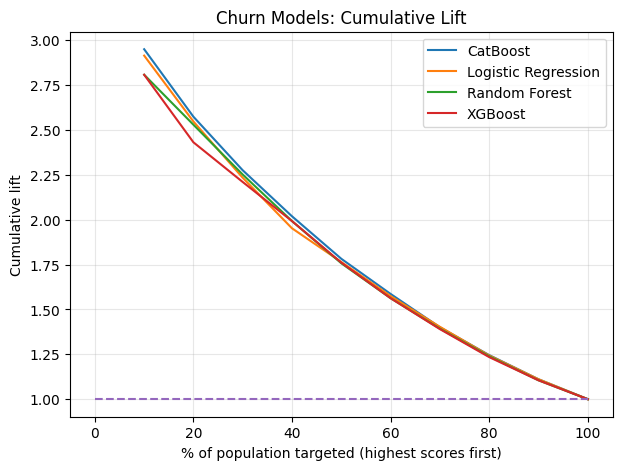

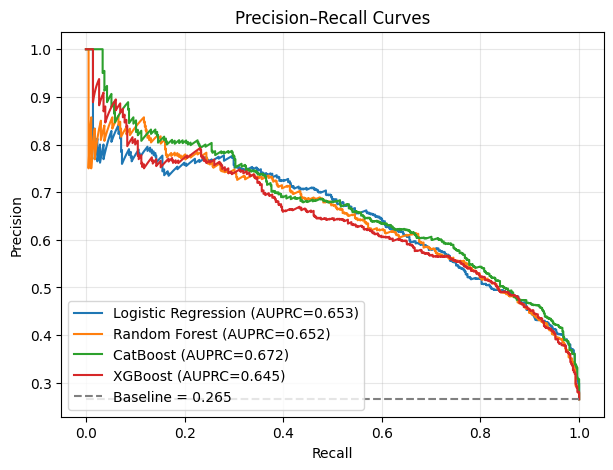

In [23]:
model_cols = ["Logistic Regression", "Random Forest", "CatBoost", "XGBoost"]

lift_df, base_rate = make_lift_tables(predictions_df, y_col="y_true", model_cols=model_cols, n_bins=10)
print("Baseline positive rate:", round(base_rate, 4))

# Plot all models on one cumulative lift chart
plot_cumulative_lift(lift_df, title="Churn Models: Cumulative Lift")

plot_pr_curves(predictions_df, y_col="y_true", model_cols=model_cols)

In [27]:
predictions_df.to_csv(dir_data + '/predictions.csv', index=False)

In [30]:
# Create a single DF with all the models' scores
scores_df = pd.concat([
    lr_results_df,
    rf_results_df,
    cb_results_df,
    xgb_results_df,
    cb_2_results_df
])

scores_df.to_csv(dir_data + '/all_scores.csv')